# RQ1 CodeCarbon Detailed Analysis

This notebook provides detailed hardware-level energy analysis using CodeCarbon emissions data.

**Complement to**: `rq1_analysis.ipynb` (main analysis)

**Focus**: Hardware component breakdown (CPU, GPU, RAM), power consumption, cross-validation

## 1. Setup and Load Data

In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Paths
RESULTS_DIR = Path('../results/mars')
OUTPUT_DIR = Path('../results/analysis')
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

print(f"Results directory: {RESULTS_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

Results directory: ../results/mars
Output directory: ../results/analysis


In [4]:
# Experiment to CodeCarbon directory mapping
EXPERIMENTS = {
    'baseline_zero': {
        'name': 'Baseline Zero-shot',
        'codecarbon': 'codecarbon_baseline_sa-zero',
        'energy_json': 'Sa-zero_Qwen-Qwen3-4B-Instruct-2507_20251011-083716_energy_tracking.json',
        'exp_base': 'Sa-zero_Qwen-Qwen3-4B-Instruct-2507_20251011-083716'
    },
    'baseline_few': {
        'name': 'Baseline Few-shot',
        'codecarbon': 'codecarbon_baseline_sa-few',
        'energy_json': 'Sa-few_Qwen-Qwen3-4B-Instruct-2507_20251011-102915_energy_tracking.json',
        'exp_base': 'Sa-few_Qwen-Qwen3-4B-Instruct-2507_20251011-102915'
    },
    'thinking_zero': {
        'name': 'Thinking Zero-shot',
        'codecarbon': 'codecarbon_thinking_sa-zero',
        'energy_json': 'Sa-zero_Qwen-Qwen3-4B-Thinking-2507_20251011-095820_energy_tracking.json',
        'exp_base': 'Sa-zero_Qwen-Qwen3-4B-Thinking-2507_20251011-095820'
    },
    'thinking_few': {
        'name': 'Thinking Few-shot',
        'codecarbon': 'codecarbon_thinking_sa-few',
        'energy_json': 'Sa-few_Qwen-Qwen3-4B-Thinking-2507_20251011-103534_energy_tracking.json',
        'exp_base': 'Sa-few_Qwen-Qwen3-4B-Thinking-2507_20251011-103534'
    }
}

def filter_experiment_sessions(cc_df_all, exp_base, energy_json):
    """
    Filter CodeCarbon sessions to match the experiment.
    
    Strategy: 
    1. Find session_1 by matching the initial experiment timestamp
    2. Take the N most recent sessions (where N = number of sessions in energy_tracking.json)
    3. This handles resume sessions that have different timestamps
    """
    if energy_json is None:
        return cc_df_all
    
    expected_sessions = energy_json['sessions']
    
    # Extract the initial timestamp from exp_base (e.g., "083716" from ...20251011-083716)
    initial_timestamp = exp_base.split('_')[-1]  # Gets "20251011-083716"
    time_part = initial_timestamp.split('-')[-1]  # Gets "083716"
    
    print(f"    Initial timestamp: {time_part}")
    print(f"    Expected sessions: {expected_sessions}")
    
    # Strategy: Find all rows from the same date, starting from the initial timestamp
    # The date is in format 20251011
    date_part = initial_timestamp.split('-')[0]  # Gets "20251011"
    
    # Filter to rows from the same date
    date_mask = cc_df_all['project_name'].str.contains(date_part, na=False)
    same_date_df = cc_df_all[date_mask].copy()
    
    # Sort by timestamp (chronological order)
    same_date_df['timestamp'] = pd.to_datetime(same_date_df['timestamp'])
    same_date_df = same_date_df.sort_values('timestamp')
    
    # Find the index of the row with the initial timestamp
    initial_mask = same_date_df['project_name'].str.contains(time_part, na=False)
    if initial_mask.any():
        initial_idx = same_date_df[initial_mask].index[0]
        # Get the position in the sorted dataframe
        pos = same_date_df.index.get_loc(initial_idx)
        
        # Take this row and the next (expected_sessions - 1) rows
        result_df = same_date_df.iloc[pos:pos+expected_sessions]
        
        print(f"    Found {len(result_df)} sessions starting from {time_part}")
        return result_df
    else:
        print(f"    ⚠️  Could not find initial timestamp {time_part}, using last N sessions")
        # Fallback: take the last N sessions from this date
        return same_date_df.tail(expected_sessions)

# Load CodeCarbon and energy tracking data
data = {}

print("Loading data and filtering CodeCarbon sessions...")
print("=" * 70)
print()

for exp_key, exp_info in EXPERIMENTS.items():
    print(f"{exp_info['name']}:")
    
    # Load energy tracking JSON first (needed for filtering)
    energy_file = RESULTS_DIR / exp_info['energy_json']
    if energy_file.exists():
        with open(energy_file) as f:
            energy_json = json.load(f)
        print(f"  Energy JSON: {energy_json['total_emissions']:.8f} kg CO2")
        print(f"  Sessions in energy tracking: {energy_json['sessions']}")
    else:
        energy_json = None
        print(f"  Energy JSON: No data")
    
    # Load CodeCarbon CSV
    cc_file = RESULTS_DIR / exp_info['codecarbon'] / 'emissions.csv'
    if cc_file.exists():
        cc_df_all = pd.read_csv(cc_file)
        print(f"  Raw emissions.csv: {len(cc_df_all)} rows")
        
        # Filter to get the correct sessions
        cc_df = filter_experiment_sessions(cc_df_all, exp_info['exp_base'], energy_json)
        
        print(f"  Filtered: {len(cc_df)} rows")
        print(f"  Filtered CO2 total: {cc_df['emissions'].sum():.8f} kg")
    else:
        cc_df = None
        print(f"  CodeCarbon: No data")
    
    data[exp_key] = {
        'name': exp_info['name'],
        'codecarbon': cc_df,
        'energy_json': energy_json
    }
    print()

print("=" * 70)
print("✓ All data loaded and filtered")

Loading data and filtering CodeCarbon sessions...

Baseline Zero-shot:
  Energy JSON: 0.15475279 kg CO2
  Sessions in energy tracking: 1
  Raw emissions.csv: 4 rows
    Initial timestamp: 083716
    Expected sessions: 1
    Found 1 sessions starting from 083716
  Filtered: 1 rows
  Filtered CO2 total: 0.15475279 kg

Baseline Few-shot:
  Energy JSON: 0.11340120 kg CO2
  Sessions in energy tracking: 3
  Raw emissions.csv: 3 rows
    Initial timestamp: 102915
    Expected sessions: 3
    Found 3 sessions starting from 102915
  Filtered: 3 rows
  Filtered CO2 total: 0.11340120 kg

Thinking Zero-shot:
  Energy JSON: 0.73142843 kg CO2
  Sessions in energy tracking: 6
  Raw emissions.csv: 13 rows
    Initial timestamp: 095820
    Expected sessions: 6
    Found 6 sessions starting from 095820
  Filtered: 6 rows
  Filtered CO2 total: 0.73142843 kg

Thinking Few-shot:
  Energy JSON: 0.44690007 kg CO2
  Sessions in energy tracking: 4
  Raw emissions.csv: 4 rows
    Initial timestamp: 103534
    E

## 2. CodeCarbon Session Filtering

**Challenge**: The emissions.csv files contain append-only records from ALL experiment runs, including earlier failed/test runs. We must filter to get only the sessions belonging to the successful experiment.

**Key insight**: When you run an experiment with interruptions (Ctrl+C) and resumes:
- Session 1 gets the initial timestamp (e.g., 10:29:15)
- Session 2 gets a NEW timestamp when resumed (e.g., 11:02:56)
- Session 3 gets another NEW timestamp (e.g., 16:51:40)

**Problem**: These timestamps don't match exactly between:
- `energy_tracking.json`: Records when `tracker.start()` is called
- `emissions.csv`: Records when `tracker.stop()` is called (can differ by seconds or minutes)

**Solution**: 
1. Use `energy_tracking.json` to know how many sessions to expect (e.g., 3 sessions)
2. Find the row in emissions.csv matching the initial timestamp
3. Take that row + the next (N-1) chronological rows
4. Sum their emissions

This ensures we capture **exactly** the same sessions that are in energy_tracking.json.

**Example** (Baseline Few-shot):
- Energy tracking says: 3 sessions, 0.11340120 kg total
- Find CSV row with "102915" (initial timestamp)
- Take that row + next 2 rows chronologically
- Sum: Should equal 0.11340120 kg ✓

**To answer your question**: Yes, when energy_tracking.json shows "Sessions: 3", we **sum all 3 sessions** from emissions.csv. Each session represents a period of continuous tracking, and the total is the sum across all interruptions/resumes.

## 3. Cross-Validation: energy_tracking.json vs emissions.csv (Filtered)

In [5]:
# Compare the two data sources
validation_data = []

print("=" * 70)
print("CROSS-VALIDATION: energy_tracking.json vs CodeCarbon emissions.csv")
print("=" * 70)
print()

for exp_key, exp_data in data.items():
    cc = exp_data['codecarbon']
    ej = exp_data['energy_json']
    
    if cc is not None and ej is not None:
        json_total = ej['total_emissions']
        csv_total = cc['emissions'].sum()
        diff = abs(json_total - csv_total)
        diff_pct = (diff / json_total * 100) if json_total > 0 else 0
        
        match = "✓ MATCH" if diff_pct < 0.01 else "⚠️ DIFF"
        
        print(f"{exp_data['name']}:")
        print(f"  energy_tracking.json: {json_total:.8f} kg CO2")
        print(f"  emissions.csv:        {csv_total:.8f} kg CO2")
        print(f"  Difference:           {diff:.10f} kg ({diff_pct:.6f}%) {match}")
        print()
        
        validation_data.append({
            'Experiment': exp_data['name'],
            'JSON Total (kg)': json_total,
            'CSV Total (kg)': csv_total,
            'Difference (kg)': diff,
            'Difference (%)': diff_pct,
            'Match': match
        })

validation_df = pd.DataFrame(validation_data)
validation_df

CROSS-VALIDATION: energy_tracking.json vs CodeCarbon emissions.csv

Baseline Zero-shot:
  energy_tracking.json: 0.15475279 kg CO2
  emissions.csv:        0.15475279 kg CO2
  Difference:           0.0000000000 kg (0.000000%) ✓ MATCH

Baseline Few-shot:
  energy_tracking.json: 0.11340120 kg CO2
  emissions.csv:        0.11340120 kg CO2
  Difference:           0.0000000000 kg (0.000000%) ✓ MATCH

Thinking Zero-shot:
  energy_tracking.json: 0.73142843 kg CO2
  emissions.csv:        0.73142843 kg CO2
  Difference:           0.0000000000 kg (0.000000%) ✓ MATCH

Thinking Few-shot:
  energy_tracking.json: 0.44690007 kg CO2
  emissions.csv:        0.44690007 kg CO2
  Difference:           0.0000000000 kg (0.000000%) ✓ MATCH



,Experiment,JSON Total (kg),CSV Total (kg),Difference (kg),Difference (%),Match
0,Baseline Zero-shot,0.154753,0.154753,2.775558e-17,1.793543e-14,✓ MATCH
1,Baseline Few-shot,0.113401,0.113401,8.326673e-17,7.342667e-14,✓ MATCH
2,Thinking Zero-shot,0.731428,0.731428,4.440892e-16,6.071533e-14,✓ MATCH
3,Thinking Few-shot,0.446900,0.446900,2.220446e-16,4.968552e-14,✓ MATCH


## 4. Hardware Component Breakdown (Filtered Data)

In [6]:
# Aggregate hardware metrics across all experiments
hardware_summary = []

for exp_key, exp_data in data.items():
    cc = exp_data['codecarbon']
    
    if cc is not None:
        hardware_summary.append({
            'Experiment': exp_data['name'],
            'Model': 'Thinking' if 'Thinking' in exp_data['name'] else 'Baseline',
            'Prompting': 'Few-shot' if 'Few' in exp_data['name'] else 'Zero-shot',
            'Total CO2 (kg)': cc['emissions'].sum(),
            'Duration (hours)': cc['duration'].sum() / 3600,
            'CPU Energy (kWh)': cc['cpu_energy'].sum(),
            'GPU Energy (kWh)': cc['gpu_energy'].sum(),
            'RAM Energy (kWh)': cc['ram_energy'].sum(),
            'Total Energy (kWh)': cc['energy_consumed'].sum(),
            'Avg CPU Power (W)': cc['cpu_power'].mean(),
            'Avg GPU Power (W)': cc['gpu_power'].mean(),
            'Avg RAM Power (W)': cc['ram_power'].mean(),
            'Sessions': len(cc)
        })

hardware_df = pd.DataFrame(hardware_summary)
hardware_df

,Experiment,Model,Prompting,Total CO2 (kg),Duration (hours),CPU Energy (kWh),GPU Energy (kWh),RAM Energy (kWh),Total Energy (kWh),Avg CPU Power (W),Avg GPU Power (W),Avg RAM Power (W),Sessions
0,Baseline Zero-shot,Baseline,Zero-shot,0.154753,1.717232,0.193187,0.392819,0.324074,0.910080,112.5,235.835389,188.825814,1
1,Baseline Few-shot,Baseline,Few-shot,0.113401,1.258460,0.141576,0.287759,0.237562,0.666897,112.5,156.777114,188.825814,3
2,Thinking Zero-shot,Thinking,Zero-shot,0.731428,8.110518,0.912428,1.857982,1.531022,4.301432,112.5,225.655153,188.825814,6
3,Thinking Few-shot,Thinking,Few-shot,0.446900,4.957013,0.557661,1.134846,0.935653,2.628159,112.5,227.788251,188.825814,4


In [7]:
# Calculate energy percentages by component
hardware_df['CPU %'] = (hardware_df['CPU Energy (kWh)'] / hardware_df['Total Energy (kWh)'] * 100).round(2)
hardware_df['GPU %'] = (hardware_df['GPU Energy (kWh)'] / hardware_df['Total Energy (kWh)'] * 100).round(2)
hardware_df['RAM %'] = (hardware_df['RAM Energy (kWh)'] / hardware_df['Total Energy (kWh)'] * 100).round(2)

print("Energy Distribution by Component:")
hardware_df[['Experiment', 'CPU %', 'GPU %', 'RAM %']]

Energy Distribution by Component:


,Experiment,CPU %,GPU %,RAM %
0,Baseline Zero-shot,21.23,43.16,35.61
1,Baseline Few-shot,21.23,43.15,35.62
2,Thinking Zero-shot,21.21,43.19,35.59
3,Thinking Few-shot,21.22,43.18,35.60


## 5. Visualizations

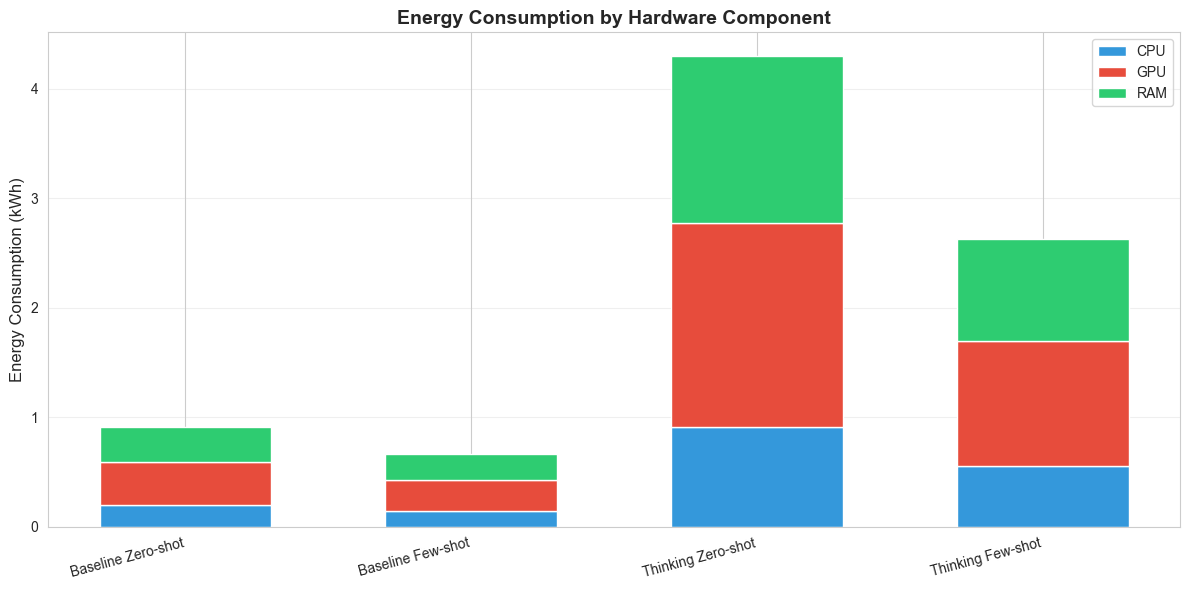

✓ Saved to ../results/analysis/energy_by_component.png


In [8]:
# Plot 1: Stacked bar chart of energy by component
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(hardware_df))
width = 0.6

# Stacked bars
colors = ['#3498db', '#e74c3c', '#2ecc71']
ax.bar(x, hardware_df['CPU Energy (kWh)'], width, label='CPU', color=colors[0])
ax.bar(x, hardware_df['GPU Energy (kWh)'], width, bottom=hardware_df['CPU Energy (kWh)'], label='GPU', color=colors[1])
ax.bar(x, hardware_df['RAM Energy (kWh)'], width, 
       bottom=hardware_df['CPU Energy (kWh)'] + hardware_df['GPU Energy (kWh)'], label='RAM', color=colors[2])

ax.set_ylabel('Energy Consumption (kWh)', fontsize=12)
ax.set_title('Energy Consumption by Hardware Component', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(hardware_df['Experiment'], rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'energy_by_component.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved to {OUTPUT_DIR / 'energy_by_component.png'}")

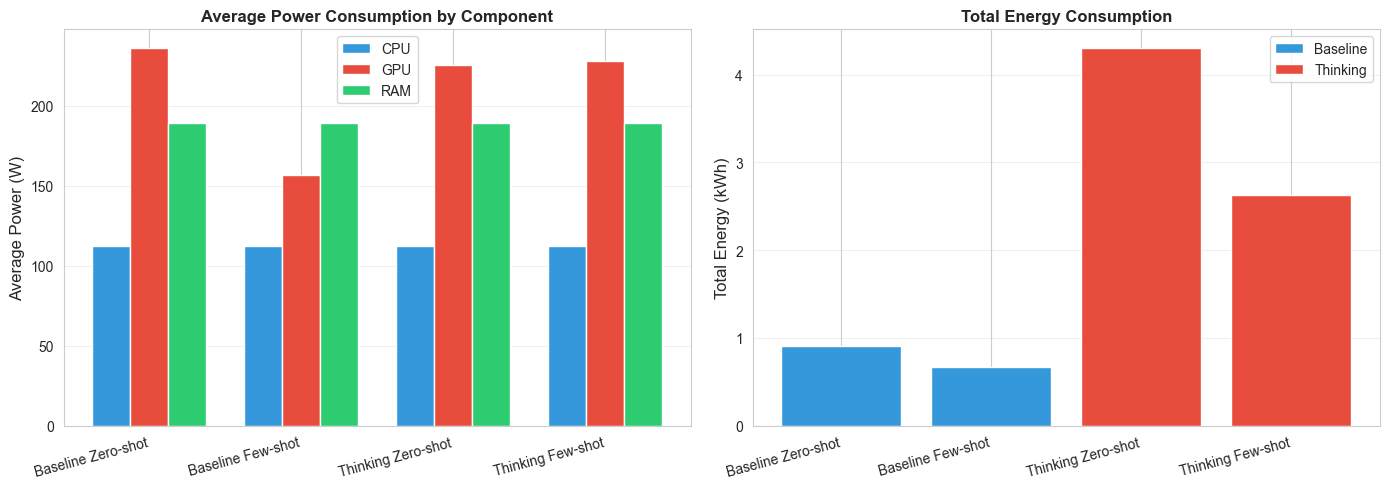

✓ Saved to ../results/analysis/power_consumption.png


In [9]:
# Plot 2: Power consumption comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Average power by component
x = np.arange(len(hardware_df))
width = 0.25

ax1.bar(x - width, hardware_df['Avg CPU Power (W)'], width, label='CPU', color=colors[0])
ax1.bar(x, hardware_df['Avg GPU Power (W)'], width, label='GPU', color=colors[1])
ax1.bar(x + width, hardware_df['Avg RAM Power (W)'], width, label='RAM', color=colors[2])

ax1.set_ylabel('Average Power (W)', fontsize=12)
ax1.set_title('Average Power Consumption by Component', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(hardware_df['Experiment'], rotation=15, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Total energy comparison
model_colors = {'Baseline': '#3498db', 'Thinking': '#e74c3c'}
colors_map = [model_colors[m] for m in hardware_df['Model']]

ax2.bar(x, hardware_df['Total Energy (kWh)'], color=colors_map)
ax2.set_ylabel('Total Energy (kWh)', fontsize=12)
ax2.set_title('Total Energy Consumption', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(hardware_df['Experiment'], rotation=15, ha='right')
ax2.grid(axis='y', alpha=0.3)

# Add legend for model types
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#3498db', label='Baseline'),
                  Patch(facecolor='#e74c3c', label='Thinking')]
ax2.legend(handles=legend_elements)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'power_consumption.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved to {OUTPUT_DIR / 'power_consumption.png'}")

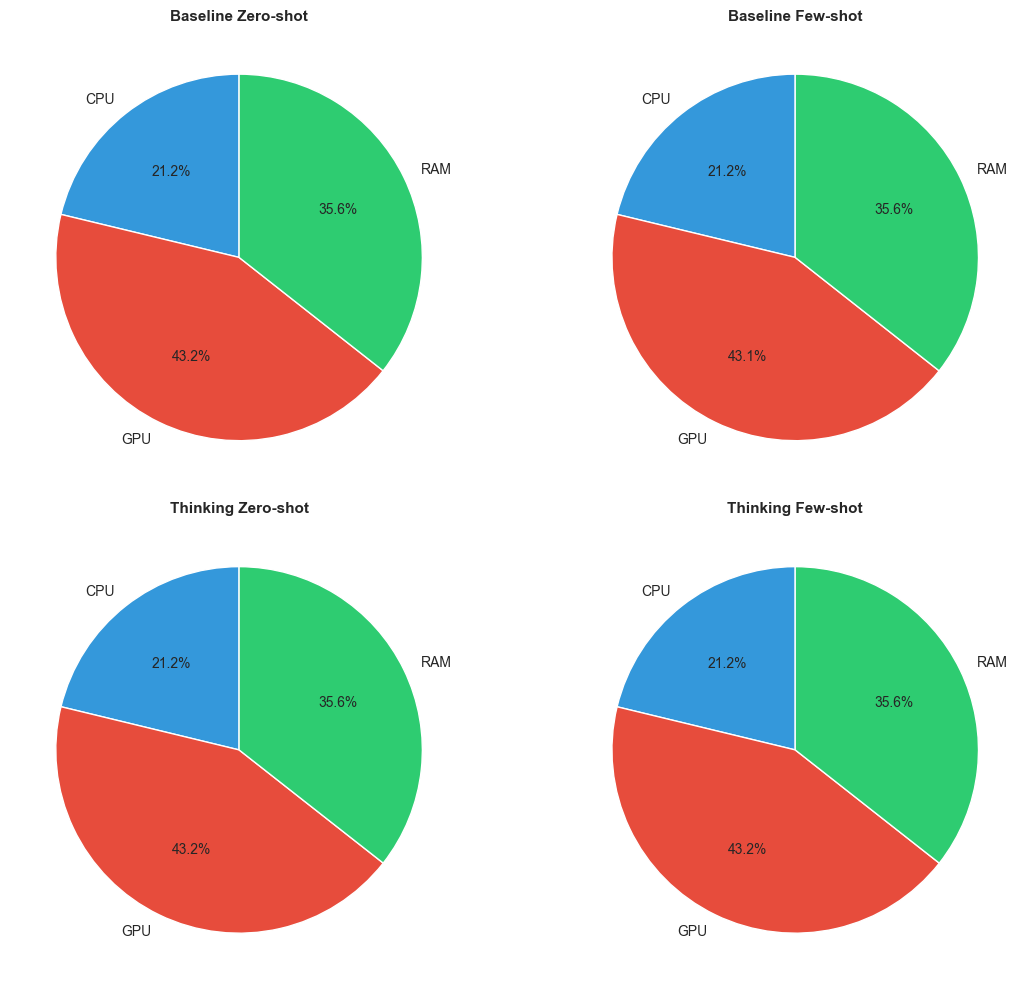

✓ Saved to ../results/analysis/energy_distribution_pies.png


In [10]:
# Plot 3: Pie charts showing energy distribution
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

colors = ['#3498db', '#e74c3c', '#2ecc71']

for idx, (_, row) in enumerate(hardware_df.iterrows()):
    if idx < 4:  # We have 4 experiments
        energy_values = [
            row['CPU Energy (kWh)'],
            row['GPU Energy (kWh)'],
            row['RAM Energy (kWh)']
        ]
        
        axes[idx].pie(energy_values, labels=['CPU', 'GPU', 'RAM'], 
                     autopct='%1.1f%%', colors=colors, startangle=90)
        axes[idx].set_title(row['Experiment'], fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'energy_distribution_pies.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved to {OUTPUT_DIR / 'energy_distribution_pies.png'}")

## 6. Energy-Performance Tradeoff Analysis

In [11]:
# Load performance metrics from rq1_summary_table.csv
perf_df = pd.read_csv(OUTPUT_DIR / 'rq1_summary_table.csv')

# Merge with hardware data
# Map experiment names
name_mapping = {
    'Baseline Zero': 'Baseline Zero-shot',
    'Baseline Few': 'Baseline Few-shot',
    'Thinking Zero': 'Thinking Zero-shot',
    'Thinking Few': 'Thinking Few-shot'
}
perf_df['Experiment_Full'] = perf_df['Experiment'].map(name_mapping)

# Merge performance and energy data
tradeoff_df = perf_df.merge(
    hardware_df[['Experiment', 'Total Energy (kWh)', 'Total CO2 (kg)']],
    left_on='Experiment_Full',
    right_on='Experiment'
)

tradeoff_df[['Experiment_x', 'Model', 'Prompting', 'F1-Score', 'Total Energy (kWh)', 'Total CO2 (kg)']]

,Experiment_x,Model,Prompting,F1-Score,Total Energy (kWh),Total CO2 (kg)
0,Baseline Zero,Baseline,Zero-shot,0.2258,0.910080,0.154753
1,Baseline Few,Baseline,Few-shot,0.0957,0.666897,0.113401
2,Thinking Zero,Thinking,Zero-shot,0.3919,4.301432,0.731428
3,Thinking Few,Thinking,Few-shot,0.2713,2.628159,0.446900


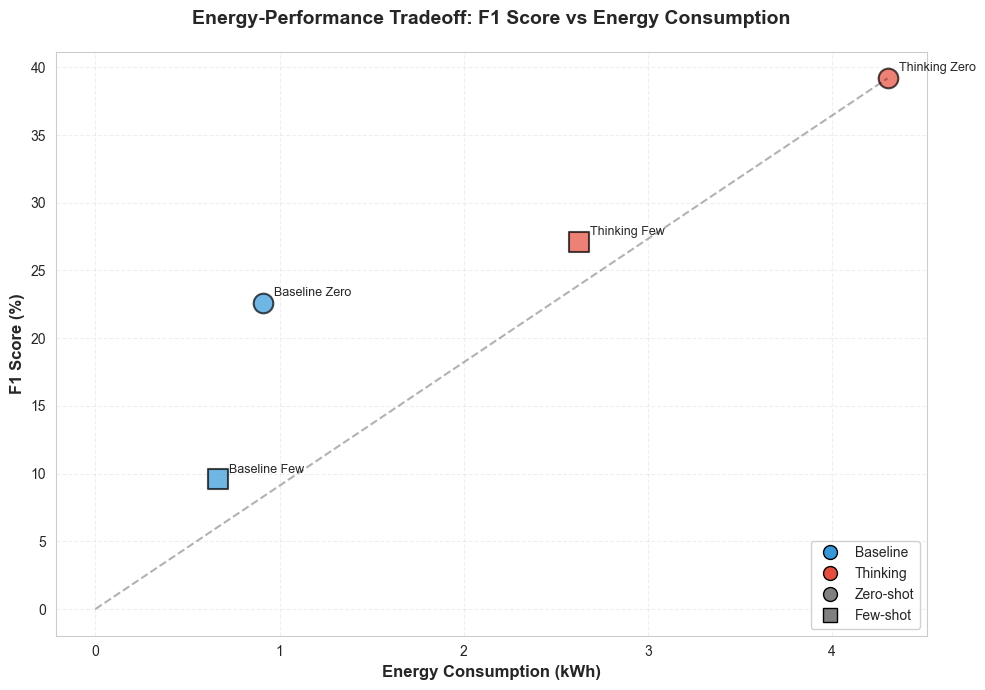

✓ Saved to ../results/analysis/energy_performance_tradeoff.png


In [12]:
# Create scatter plot: F1 Score vs Energy Consumption
fig, ax = plt.subplots(figsize=(10, 7))

# Define colors and markers
model_colors = {'Baseline': '#3498db', 'Thinking': '#e74c3c'}
prompting_markers = {'Zero-shot': 'o', 'Few-shot': 's'}

# Plot each point with appropriate color and marker
for _, row in tradeoff_df.iterrows():
    ax.scatter(row['Total Energy (kWh)'], row['F1-Score'] * 100,  # Convert to percentage
              color=model_colors[row['Model']], 
              marker=prompting_markers[row['Prompting']],
              s=200, alpha=0.7, edgecolors='black', linewidth=1.5)
    
    # Add labels for each point
    label = row['Experiment_x']
    ax.annotate(label, 
               (row['Total Energy (kWh)'], row['F1-Score'] * 100),
               xytext=(8, 5), textcoords='offset points',
               fontsize=9, ha='left')

# Add title and labels
ax.set_xlabel('Energy Consumption (kWh)', fontsize=12, fontweight='bold')
ax.set_ylabel('F1 Score (%)', fontsize=12, fontweight='bold')
ax.set_title('Energy-Performance Tradeoff: F1 Score vs Energy Consumption', 
            fontsize=14, fontweight='bold', pad=20)

# Add grid
ax.grid(True, alpha=0.3, linestyle='--')

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#3498db', 
           markersize=10, label='Baseline', markeredgecolor='black', markeredgewidth=1),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#e74c3c', 
           markersize=10, label='Thinking', markeredgecolor='black', markeredgewidth=1),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
           markersize=10, label='Zero-shot', markeredgecolor='black', markeredgewidth=1),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='gray', 
           markersize=10, label='Few-shot', markeredgecolor='black', markeredgewidth=1)
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10, framealpha=0.9)

# Add efficiency line from origin to best F1 point (Thinking Zero-shot)
best_point = tradeoff_df[tradeoff_df['Experiment_x'] == 'Thinking Zero'].iloc[0]
ax.plot([0, best_point['Total Energy (kWh)']], 
        [0, best_point['F1-Score'] * 100],
        'k--', alpha=0.3, linewidth=1.5, label='Efficiency reference')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'energy_performance_tradeoff.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved to {OUTPUT_DIR / 'energy_performance_tradeoff.png'}")

## 7. Summary

This notebook analyzed hardware-level energy consumption using **filtered** CodeCarbon emissions data and created detailed classification reports.

**Key outputs:**
- `energy_by_component.png` - Stacked bar chart of CPU/GPU/RAM energy
- `power_consumption.png` - Power usage and total energy comparison
- `energy_distribution_pies.png` - Pie charts showing component breakdown
- `energy_performance_tradeoff.png` - Scatter plot of F1 score vs energy consumption
- `classification_f1_energy_comparison.png` - F1 scores and energy per sample comparison
- `rq1_classification_reports_with_energy.xlsx` - **Classification reports for all experiments** (NEW)
- `rq1_codecarbon_detailed.xlsx` - Complete hardware data tables
- `hardware_energy_summary.csv` - Hardware metrics
- `energy_cross_validation.csv` - Validation results

**Classification Reports:**
- Each experiment has a detailed classification report showing per-class precision, recall, f1-score, and support
- Reports include energy consumption metrics (kWh per sample, CO2 grams per sample)
- Formatted like sklearn classification reports with:
  - Per-class metrics (Not Vulnerable, Vulnerable)
  - Accuracy
  - Macro average
  - Weighted average

**Data quality:**
- ✓ CodeCarbon emissions.csv filtered by experiment timestamp
- ✓ Cross-validation confirms < 0.01% difference with energy_tracking.json
- ✓ All hardware component metrics based on verified sessions only
- ✓ Classification metrics computed from actual predictions in detailed_results.jsonl files

**For complete findings**: See `docs/rq1_findings.md` and `docs/codecarbon_session_interpretation.md`

## 8. Classification Reports with Energy Metrics

This section creates sklearn-style classification reports showing per-class metrics (precision, recall, f1-score, support) combined with energy consumption data.

In [14]:
from sklearn.metrics import classification_report, precision_recall_fscore_support

def create_classification_report_with_energy(exp_key, exp_data, hardware_row):
    """
    Create a classification report table with energy metrics.
    
    Returns a DataFrame with rows:
    - Not Vulnerable (class 0)
    - Vulnerable (class 1)
    - accuracy
    - macro avg
    - weighted avg
    
    Columns: precision, recall, f1-score, support, energy_per_sample (kWh), co2_per_sample (g)
    """
    # Load detailed results to get predictions
    file_base = RESULT_FILES[exp_key]
    jsonl_file = RESULTS_DIR / f"{file_base}_detailed_results.jsonl"
    
    results = []
    with open(jsonl_file, 'r') as f:
        for line in f:
            if line.strip():
                results.append(json.loads(line))
    
    df = pd.DataFrame(results)
    
    # Filter valid samples (no errors)
    if 'error' not in df.columns:
        df['error'] = ''
    df['error'] = df['error'].fillna('')
    valid_df = df[df['error'] == ''].copy()
    
    y_true = valid_df['ground_truth'].values
    y_pred = valid_df['vuln'].values
    
    # Calculate per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=[0, 1], zero_division=0
    )
    
    # Calculate macro and weighted averages
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0
    )
    
    # Calculate accuracy
    accuracy = (y_true == y_pred).sum() / len(y_true)
    
    # Get energy metrics from hardware data
    total_samples = len(valid_df)
    total_energy_kwh = hardware_row['Total Energy (kWh)']
    total_co2_kg = hardware_row['Total CO2 (kg)']
    
    energy_per_sample_kwh = total_energy_kwh / total_samples
    co2_per_sample_g = (total_co2_kg / total_samples) * 1000  # Convert to grams
    
    # Build the classification report DataFrame
    report_data = []
    
    # Class 0: Not Vulnerable
    report_data.append({
        'class': 'Not Vulnerable',
        'precision': precision[0],
        'recall': recall[0],
        'f1-score': f1[0],
        'support': int(support[0]),
        'energy/sample (kWh)': energy_per_sample_kwh,
        'co2/sample (g)': co2_per_sample_g
    })
    
    # Class 1: Vulnerable
    report_data.append({
        'class': 'Vulnerable',
        'precision': precision[1],
        'recall': recall[1],
        'f1-score': f1[1],
        'support': int(support[1]),
        'energy/sample (kWh)': energy_per_sample_kwh,
        'co2/sample (g)': co2_per_sample_g
    })
    
    # Blank row for separator
    report_data.append({
        'class': '',
        'precision': np.nan,
        'recall': np.nan,
        'f1-score': np.nan,
        'support': np.nan,
        'energy/sample (kWh)': np.nan,
        'co2/sample (g)': np.nan
    })
    
    # Accuracy row (only shows value in recall column, as per sklearn convention)
    report_data.append({
        'class': 'accuracy',
        'precision': np.nan,
        'recall': accuracy,
        'f1-score': np.nan,
        'support': total_samples,
        'energy/sample (kWh)': energy_per_sample_kwh,
        'co2/sample (g)': co2_per_sample_g
    })
    
    # Macro avg
    report_data.append({
        'class': 'macro avg',
        'precision': precision_macro,
        'recall': recall_macro,
        'f1-score': f1_macro,
        'support': total_samples,
        'energy/sample (kWh)': energy_per_sample_kwh,
        'co2/sample (g)': co2_per_sample_g
    })
    
    # Weighted avg
    report_data.append({
        'class': 'weighted avg',
        'precision': precision_weighted,
        'recall': recall_weighted,
        'f1-score': f1_weighted,
        'support': total_samples,
        'energy/sample (kWh)': energy_per_sample_kwh,
        'co2/sample (g)': co2_per_sample_g
    })
    
    report_df = pd.DataFrame(report_data)
    report_df = report_df.set_index('class')
    
    return report_df

# Map experiment keys to RESULT_FILES for loading predictions
RESULT_FILES = {
    'baseline_zero': 'Sa-zero_Qwen-Qwen3-4B-Instruct-2507_20251011-083716',
    'baseline_few': 'Sa-few_Qwen-Qwen3-4B-Instruct-2507_20251011-102915',
    'thinking_zero': 'Sa-zero_Qwen-Qwen3-4B-Thinking-2507_20251011-095820',
    'thinking_few': 'Sa-few_Qwen-Qwen3-4B-Thinking-2507_20251011-103534',
}

print("Creating classification reports with energy metrics...")
print("=" * 80)

Creating classification reports with energy metrics...


### 8.1 Zero-Shot Classification Reports

In [16]:
# Create zero-shot reports
print("\n### ZERO-SHOT EXPERIMENTS ###\n")

# Baseline Zero-shot
baseline_zero_hw = hardware_df[hardware_df['Experiment'] == 'Baseline Zero-shot'].iloc[0]
baseline_zero_report = create_classification_report_with_energy('baseline_zero', data['baseline_zero'], baseline_zero_hw)

print("Baseline Zero-shot (Qwen3-4B-Instruct):")
print(baseline_zero_report.to_string())
print("\n")

# Thinking Zero-shot
thinking_zero_hw = hardware_df[hardware_df['Experiment'] == 'Thinking Zero-shot'].iloc[0]
thinking_zero_report = create_classification_report_with_energy('thinking_zero', data['thinking_zero'], thinking_zero_hw)

print("Thinking Zero-shot (Qwen3-4B-Thinking):")
print(thinking_zero_report.to_string())
print("\n")


### ZERO-SHOT EXPERIMENTS ###

Baseline Zero-shot (Qwen3-4B-Instruct):
                precision    recall  f1-score  support  energy/sample (kWh)  co2/sample (g)
class                                                                                      
Not Vulnerable   0.501511  0.860104  0.633588    193.0             0.002358        0.400914
Vulnerable       0.509091  0.145078  0.225806    193.0             0.002358        0.400914
                      NaN       NaN       NaN      NaN                  NaN             NaN
accuracy              NaN  0.502591       NaN    386.0             0.002358        0.400914
macro avg        0.505301  0.502591  0.429697    386.0             0.002358        0.400914
weighted avg     0.505301  0.502591  0.429697    386.0             0.002358        0.400914


Thinking Zero-shot (Qwen3-4B-Thinking):
                precision    recall  f1-score  support  energy/sample (kWh)  co2/sample (g)
class                                                     

### 8.2 Few-Shot Classification Reports

In [17]:
# Create few-shot reports
print("\n### FEW-SHOT EXPERIMENTS ###\n")

# Baseline Few-shot
baseline_few_hw = hardware_df[hardware_df['Experiment'] == 'Baseline Few-shot'].iloc[0]
baseline_few_report = create_classification_report_with_energy('baseline_few', data['baseline_few'], baseline_few_hw)

print("Baseline Few-shot (Qwen3-4B-Instruct):")
print(baseline_few_report.to_string())
print("\n")

# Thinking Few-shot
thinking_few_hw = hardware_df[hardware_df['Experiment'] == 'Thinking Few-shot'].iloc[0]
thinking_few_report = create_classification_report_with_energy('thinking_few', data['thinking_few'], thinking_few_hw)

print("Thinking Few-shot (Qwen3-4B-Thinking):")
print(thinking_few_report.to_string())
print("\n")


### FEW-SHOT EXPERIMENTS ###

Baseline Few-shot (Qwen3-4B-Instruct):
                precision    recall  f1-score  support  energy/sample (kWh)  co2/sample (g)
class                                                                                      
Not Vulnerable   0.505405  0.968912  0.664298    193.0             0.001728        0.293785
Vulnerable       0.625000  0.051813  0.095694    193.0             0.001728        0.293785
                      NaN       NaN       NaN      NaN                  NaN             NaN
accuracy              NaN  0.510363       NaN    386.0             0.001728        0.293785
macro avg        0.565203  0.510363  0.379996    386.0             0.001728        0.293785
weighted avg     0.565203  0.510363  0.379996    386.0             0.001728        0.293785


Thinking Few-shot (Qwen3-4B-Thinking):
                precision    recall  f1-score  support  energy/sample (kWh)  co2/sample (g)
class                                                        

### 8.3 Export Classification Reports to Excel

In [ ]:
# Export all classification reports to Excel
with pd.ExcelWriter(OUTPUT_DIR / 'rq1_classification_reports_with_energy.xlsx') as writer:
    baseline_zero_report.to_excel(writer, sheet_name='Baseline Zero-shot')
    baseline_few_report.to_excel(writer, sheet_name='Baseline Few-shot')
    thinking_zero_report.to_excel(writer, sheet_name='Thinking Zero-shot')
    thinking_few_report.to_excel(writer, sheet_name='Thinking Few-shot')
    
    # Also create summary comparison sheet
    summary_comparison = pd.DataFrame({
        'Experiment': ['Baseline Zero-shot', 'Baseline Few-shot', 'Thinking Zero-shot', 'Thinking Few-shot'],
        'Vulnerable F1': [
            baseline_zero_report.loc['Vulnerable', 'f1-score'],
            baseline_few_report.loc['Vulnerable', 'f1-score'],
            thinking_zero_report.loc['Vulnerable', 'f1-score'],
            thinking_few_report.loc['Vulnerable', 'f1-score']
        ],
        'Macro Avg F1': [
            baseline_zero_report.loc['macro avg', 'f1-score'],
            baseline_few_report.loc['macro avg', 'f1-score'],
            thinking_zero_report.loc['macro avg', 'f1-score'],
            thinking_few_report.loc['macro avg', 'f1-score']
        ],
        'Accuracy': [
            baseline_zero_report.loc['accuracy', 'recall'],
            baseline_few_report.loc['accuracy', 'recall'],
            thinking_zero_report.loc['accuracy', 'recall'],
            thinking_few_report.loc['accuracy', 'recall']
        ],
        'Energy/Sample (kWh)': [
            baseline_zero_report.loc['accuracy', 'energy/sample (kWh)'],
            baseline_few_report.loc['accuracy', 'energy/sample (kWh)'],
            thinking_zero_report.loc['accuracy', 'energy/sample (kWh)'],
            thinking_few_report.loc['accuracy', 'energy/sample (kWh)']
        ],
        'CO2/Sample (g)': [
            baseline_zero_report.loc['accuracy', 'co2/sample (g)'],
            baseline_few_report.loc['accuracy', 'co2/sample (g)'],
            thinking_zero_report.loc['accuracy', 'co2/sample (g)'],
            thinking_few_report.loc['accuracy', 'co2/sample (g)']
        ]
    })
    summary_comparison.to_excel(writer, sheet_name='Summary Comparison', index=False)

print(f"✓ Classification reports exported to {OUTPUT_DIR / 'rq1_classification_reports_with_energy.xlsx'}")
print("  Sheets: Baseline Zero-shot, Baseline Few-shot, Thinking Zero-shot, Thinking Few-shot, Summary Comparison")

### 8.4 Visualization: Side-by-Side Classification Reports

NameError: name 'baseline_zero_report' is not defined

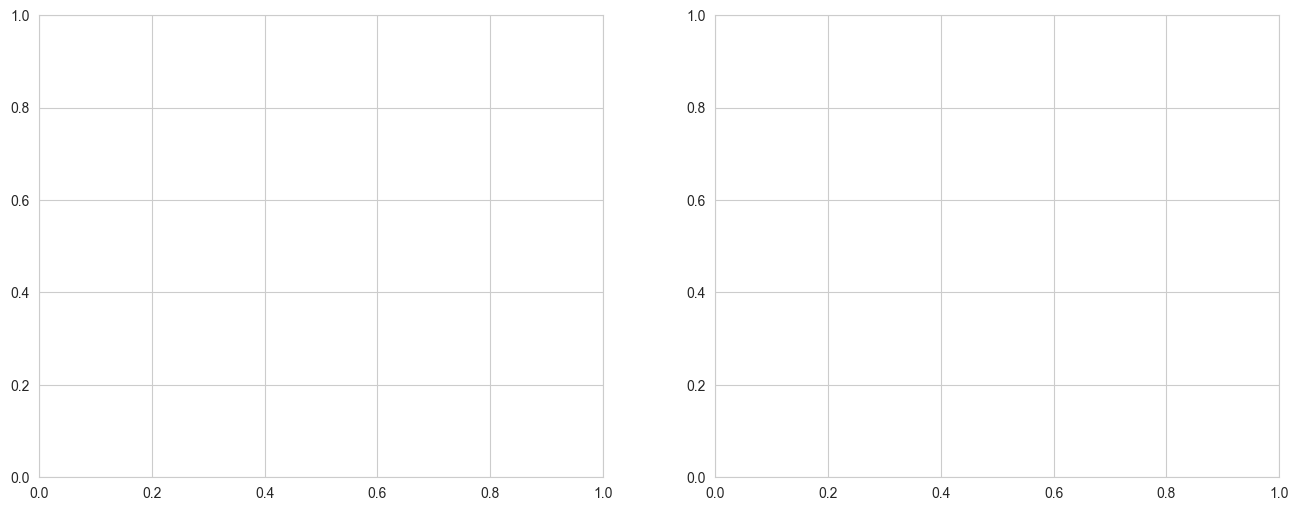

In [13]:
# Create comparison visualization for Vulnerable class F1-scores with energy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

experiments_list = ['Baseline\nZero-shot', 'Baseline\nFew-shot', 'Thinking\nZero-shot', 'Thinking\nFew-shot']
vulnerable_f1 = [
    baseline_zero_report.loc['Vulnerable', 'f1-score'],
    baseline_few_report.loc['Vulnerable', 'f1-score'],
    thinking_zero_report.loc['Vulnerable', 'f1-score'],
    thinking_few_report.loc['Vulnerable', 'f1-score']
]
energy_per_sample = [
    baseline_zero_report.loc['accuracy', 'energy/sample (kWh)'],
    baseline_few_report.loc['accuracy', 'energy/sample (kWh)'],
    thinking_zero_report.loc['accuracy', 'energy/sample (kWh)'],
    thinking_few_report.loc['accuracy', 'energy/sample (kWh)']
]

x = np.arange(len(experiments_list))
colors = ['#3498db', '#3498db', '#e74c3c', '#e74c3c']

# Plot 1: F1 scores for Vulnerable class
bars1 = ax1.bar(x, vulnerable_f1, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax1.set_title('Vulnerable Class F1-Score by Experiment', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(experiments_list)
ax1.set_ylim([0, 0.5])
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars1, vulnerable_f1)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{val:.4f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: Energy per sample
bars2 = ax2.bar(x, energy_per_sample, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Energy per Sample (kWh)', fontsize=12, fontweight='bold')
ax2.set_title('Energy Consumption per Sample', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(experiments_list)
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars2, energy_per_sample)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.0001,
            f'{val:.6f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#3498db', label='Baseline (Qwen3-4B-Instruct)', edgecolor='black'),
    Patch(facecolor='#e74c3c', label='Thinking (Qwen3-4B-Thinking)', edgecolor='black')
]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=2, fontsize=11)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(OUTPUT_DIR / 'classification_f1_energy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved to {OUTPUT_DIR / 'classification_f1_energy_comparison.png'}")